# Why R? Webinar - Uplift modeling for marketing campaigns 

## Introduction

The notebook contains an example of uplift modelling workflow with particular focus on key steps and methods specific to this problem. In particular we cover overview of the data, testing randomness of treatment/control groups split and training and validation of T-learner, uplift tree and uplift forrest.

For sake of the example we use subsample of un-biased [Criterio dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/), see Diemert, et al. (2018).

## Data

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data_all = pd.read_csv("criteo-uplift-v2.csv")

In [3]:
random.seed(321)
data = data_all.iloc[random.sample(range(0, data_all.shape[0]-1), 100000, ),:]

In [5]:
data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
4621442,14.118014,10.059654,8.214383,2.934780,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
6558938,25.325965,10.059654,8.970772,4.679882,10.280525,4.115453,-5.576414,4.833815,3.943716,13.190056,5.300375,-0.168679,0,0,0,0
2106431,24.335416,10.059654,8.214383,4.679882,10.280525,4.115453,-9.404879,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
6282350,26.175279,10.059654,8.214383,4.679882,10.280525,2.230907,-13.353455,11.804849,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
9423491,17.381600,10.059654,8.214383,3.907662,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13781123,12.616365,10.059654,8.288535,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,1,0,0,0
547178,17.877143,10.059654,8.214383,-1.025575,10.280525,4.115453,-11.398781,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
8116968,19.586073,10.059654,8.630643,3.907662,10.280525,4.115453,-1.288207,4.833815,3.845448,36.503025,5.300375,-0.168679,1,0,0,0
3070051,21.602238,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [43]:
data.groupby("treatment").mean()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,conversion,visit,exposure
treatment,,,,,,,,,,,,,,,
0,19.567584,10.068938,8.450647,4.219744,10.338940,4.037685,-4.013463,5.080501,3.934570,15.899749,5.331735,-0.171134,0.001815,0.039583,0.000000
1,19.624415,10.070285,8.445724,4.173547,10.340257,4.026979,-4.184455,5.105201,3.933364,16.068846,5.334335,-0.171021,0.003325,0.049295,0.035832


## Exploratory data analysis - split randomness

### Model

In [7]:
features_names = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"]

In [8]:
x_data = data[features_names].values

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

x_train, x_test, treatment_train, treatment_test = train_test_split(
        x_data, data['treatment'].values, test_size=0.2, random_state=42
    )

model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, treatment_train)

preds = model.predict_proba(x_test)

roc_auc_score(treatment_test, preds[:, 1])

0.500607702803086

### Distribution overview

In [42]:
data.groupby("treatment").mean()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,conversion,visit,exposure
treatment,,,,,,,,,,,,,,,
0,19.567584,10.068938,8.450647,4.219744,10.338940,4.037685,-4.013463,5.080501,3.934570,15.899749,5.331735,-0.171134,0.001815,0.039583,0.000000
1,19.624415,10.070285,8.445724,4.173547,10.340257,4.026979,-4.184455,5.105201,3.933364,16.068846,5.334335,-0.171021,0.003325,0.049295,0.035832


In [10]:
data[["f9", "treatment"]].groupby("treatment").describe()

f9                                                        \
             count       mean       std        min        25%        50%   
treatment                                                                  
0          14880.0  15.899749  6.813396  13.190056  13.190056  13.190056   
1          85120.0  16.068846  7.079823  13.190056  13.190056  13.190056   

                                 
                 75%        max  
treatment                        
0          13.190056  63.090938  
1          13.190056  61.594747

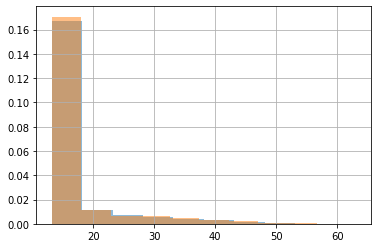

In [11]:
data[data["treatment"]==0]["f9"].hist(density=True, alpha = 0.5)
data[data["treatment"]==1]["f9"].hist(density=True, alpha = 0.5)

### Testing

In [12]:
import scipy
scipy.stats.ks_2samp(data[data["treatment"]==0]["f9"], data[data["treatment"]==1]["f9"])

Ks_2sampResult(statistic=0.009457742137602088, pvalue=0.20724300875603618)

## Models, see Chen, et al. (2020)

### Data split

In [13]:
x_train, x_test, treatment_train, treatment_test, outcome_train, outcome_test = train_test_split(
        x_data, data['treatment'].values, data['visit'].values, test_size=0.2, random_state=42
    )

### Meta - learner: T-learner

In [14]:
from causalml.inference.meta import BaseTClassifier

from xgboost import XGBClassifier

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


#### Training

In [15]:
%%time
xgb_tlearner = BaseTClassifier(learner=XGBClassifier(random_state=42, n_estimators = 300,
                               max_depth = 5, learning_rate = 0.1))

xgb_tlearner.fit(X=x_train, y=outcome_train, treatment=treatment_train)

CPU times: user 14.3 s, sys: 28 ms, total: 14.3 s
Wall time: 14.3 s


In [44]:
xgb_tlearner

BaseTClassifier(model_c=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=42, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None), model_t=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_chil

#### Validation

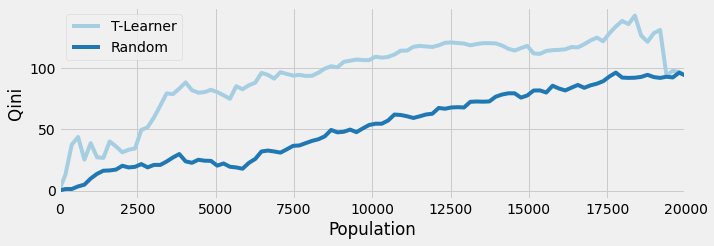

In [16]:
from causalml.metrics import plot

t_pred = xgb_tlearner.predict(X=x_test)

## Aggregating everything on a dataframe
valid_t = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                   'T-Learner': t_pred.reshape(-1), 
                  })

## Plotting the 3 types of uplift curve. 
plot(valid_t,kind='qini', outcome_col='y', treatment_col='w',figsize=(10, 3.3))

In [39]:
from causalml.metrics import auuc_score, qini_score
print('AUUC:\n',auuc_score(valid_t))

AUUC:
 T-Learner    1.019266
Random       0.558178
dtype: float64


### Uplift trees

In [18]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [19]:
%%time
uplift_tree = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name="control")

uplift_tree.fit(x_train,
                 np.where(treatment_train<1, "control", "treatment"),
                 y=outcome_train)

CPU times: user 1.64 s, sys: 184 ms, total: 1.82 s
Wall time: 1.82 s


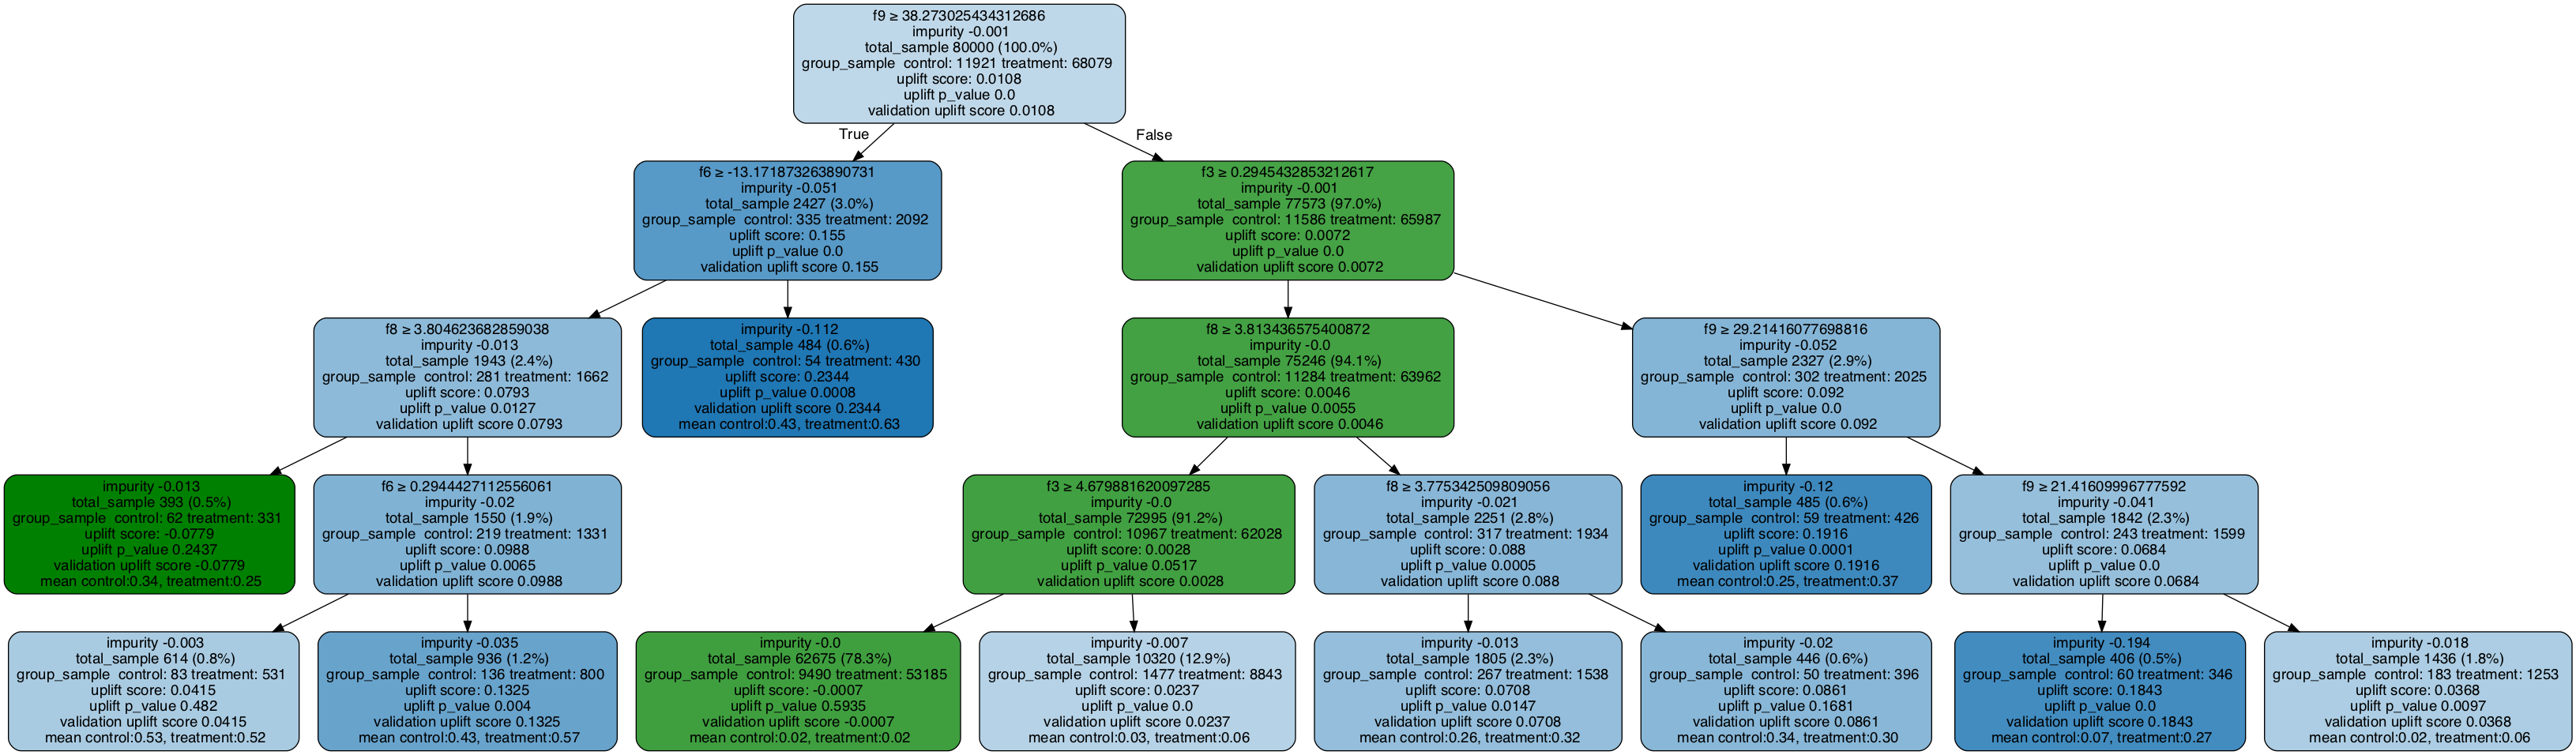

In [20]:
from IPython.display import Image

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features_names)
Image(graph.create_png())

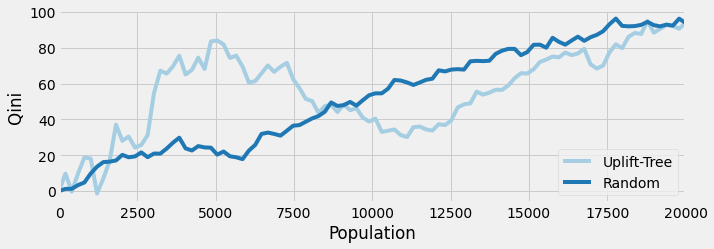

In [21]:
tree_pred = uplift_tree.predict(X=x_test)[1]

## Aggregating everything on a dataframe
valid_tree = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                   'Uplift-Tree': tree_pred, 
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_tree,kind='qini', outcome_col='y', treatment_col='w',figsize=(10, 3.3))

In [38]:
print('AUUC:\n',auuc_score(valid_tree))

AUUC:
 Uplift-Tree    0.593774
Random         0.558178
dtype: float64


### Random uplift forrest 

In [23]:
%%time
uplift_forrest = UpliftRandomForestClassifier(n_estimators=400, max_depth=14, min_samples_leaf=80, min_samples_treatment=50,
                                    n_reg=10, evaluationFunction='KL', control_name="control")

uplift_forrest.fit(x_train,
                 np.where(treatment_train<1, "control", "treatment"),
                 y=outcome_train)

CPU times: user 21min 1s, sys: 1min 38s, total: 22min 39s
Wall time: 22min 44s


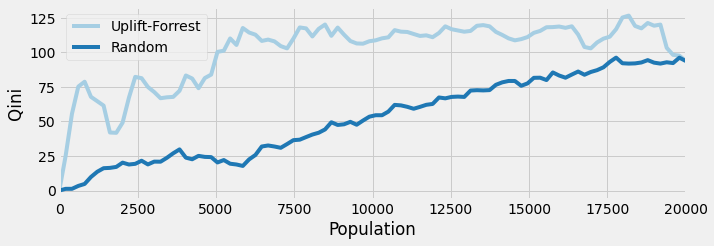

In [24]:
forrest_pred = uplift_forrest.predict(X=x_test)

## Aggregating everything on a dataframe
valid_forrest = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                   'Uplift-Forrest': forrest_pred.reshape(-1), 
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_forrest,kind='qini', outcome_col='y', treatment_col='w',figsize=(10, 3.3))

In [37]:
print('AUUC:\n',auuc_score(valid_forrest))

AUUC:
 Uplift-Forrest    1.073830
Random            0.558178
dtype: float64


### Propensity score

In [26]:
%%time
model_prop = XGBClassifier(random_state=42, n_estimators = 200,
                               max_depth = 4, learning_rate = 0.1)
model_prop.fit(x_train[treatment_train == 1], outcome_train[treatment_train == 1])

CPU times: user 6.52 s, sys: 12.7 ms, total: 6.53 s
Wall time: 6.54 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

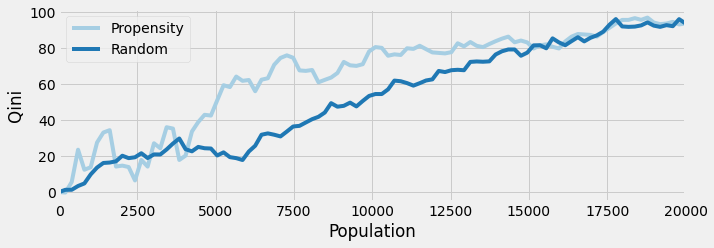

In [27]:
## Aggregating everything on a dataframe
valid_prop = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                   'Propensity': model_prop.predict_proba(x_test)[:,1], 
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_prop, kind='qini', outcome_col='y', treatment_col='w',figsize=(10, 3.3))

In [36]:
print('AUUC:\n',auuc_score(valid_prop))

AUUC:
 Propensity    0.693945
Random        0.558178
dtype: float64


## Compare all

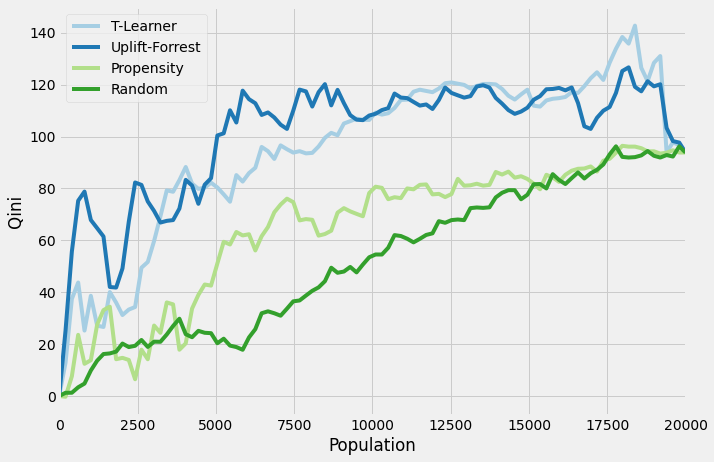

In [32]:
valid_all = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                    'T-Learner': t_pred.reshape(-1),
                   'Uplift-Forrest': forrest_pred.reshape(-1), 
                    'Propensity': model_prop.predict_proba(x_test)[:,1]
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_all,kind='qini', outcome_col='y', treatment_col='w',figsize=(10, 7))

In [35]:
print('AUUC:\n',auuc_score(valid_all))

AUUC:
 T-Learner         1.019266
Uplift-Forrest    1.073841
Propensity        0.695586
Random            0.558178
dtype: float64


# References
1. Chen, H., Harinen, T., Lee, J. Y., Yung, M., & Zhao, Z. (2020). CausalML: Python Package for Causal Machine Learning. _arXiv preprint arXiv:2002.11631._
2. Diemert, E., Betlei, A., Renaudin, C., & Amini, M. R. (2018, August). A large scale benchmark for uplift modeling. In _Proceedings of the AdKDD and TargetAd Workshop, KDD, London, United Kingdom._
    
